In [1]:
import jax
import jax.numpy as np
import numpy as onp
from matplotlib import pyplot as plt
import matplotlib as mpl
import typing
from typing import Tuple
from scipy.stats import sem
from scipy.interpolate import interp1d
import pickle
import seaborn as sns
from seaborn import cubehelix_palette
import time
import dill as pickle
from functools import partial
import time


from jax import config
config.update('jax_enable_x64', True)


sns.set_style("white")
mpl.rcParams['axes.grid']  = True
mpl.rcParams['axes.grid.which']  = 'both'
mpl.rcParams['xtick.minor.visible']  = True
mpl.rcParams['ytick.minor.visible']  = True
mpl.rcParams['xtick.minor.visible']  = True
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['grid.color'] = '0.8'
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.titlesize'] = 30
mpl.rcParams['font.size'] = 27.5
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['figure.dpi'] = 125

# Gillespie Simulation

In [2]:
@jax.jit
def calc_dFs(
    Jijs: np.ndarray, 
    his: np.ndarray, 
    spins: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    Jspin = Jijs @ spins
    dFs   = -2*spins*(his + 2*Jspin)
    return dFs


def draw_disorder(
    beta: float, 
    L: int, 
    rho: float, 
    Delta: float
) -> Tuple[np.ndarray, np.ndarray]:
    """ Draws the values for the quenched disorder. """
    sigh = onp.sqrt(1-beta)*Delta
    sigJ = onp.sqrt(beta/(L*rho))*Delta/2

    his  = sigh*onp.random.randn(L)
    Jijs = onp.zeros((L, L))

    # draw the interaction matrix.
    for ii in range(L):
        for jj in range(ii+1, L):
            if onp.random.random() < rho:
                Jijs[ii, jj] = Jijs[jj, ii] = sigJ*onp.random.randn()

    return Jijs, his


@partial(jax.jit, static_argnums=(3, 4))
def compute_initial_spin_sequence(
    key: np.ndarray,
    Jijs: np.ndarray,
    his: np.ndarray,
    rank: int,
    L: int
) -> Tuple[np.ndarray, float]:
    """ Computes a sequence of spins that has the desired rank. """
    # draw a random initial spin sequence
    spins    = jax.random.rademacher(key, shape=(L,))
    dFs      = calc_dFs(Jijs, his, spins)
    key      = jax.random.split(key)[0]
    
    # (spins, dFs, key)
    cond_fun = lambda state_tup: np.sum(state_tup[1] > 0) > rank


    def body_fun(state_tup):
        spins, dFs, key = state_tup
        beneficial_inds = dFs > 0
        p               = beneficial_inds / np.sum(beneficial_inds)
        flip_ind        = jax.random.choice(key, np.arange(L), p=p)
        spins_next      = spins.at[flip_ind].multiply(-1)
        dFs_next        = calc_dFs(Jijs, his, spins_next)
        key_next        = jax.random.split(key)[0]
        
        return spins_next, dFs_next, key_next


    return jax.lax.while_loop(cond_fun, body_fun, (spins, dFs, key))

In [3]:
def flip_spin(
    key: np.ndarray,
    r1: float,
    alpha0: float,
    props: np.ndarray,
    spins: np.ndarray,
    dFs: np.ndarray,
    fitness: float,
    time: float,
    Jijs: np.ndarray,
    his: np.ndarray
) -> Tuple:
    # time of next mutation
    tau = np.log(1.0/r1)/alpha0

    # find the chosen mutation.
    flip_index = jax.random.choice(key, np.arange(L), p=props/alpha0)
    key        = jax.random.split(key)[0]
    dF         = dFs[flip_index]

    # update the system state
    spins_next   = spins.at[flip_index].multiply(-1)
    dFs_next     = calc_dFs(Jijs, his, spins_next)
    fitness_next = fitness + dF
    time_next    = time + tau
    
    return spins_next, dFs_next, fitness_next, time_next, dF, key


def do_nothing(
    key: np.ndarray,
    r1: float,
    alpha0: float,
    props: np.ndarray,
    spins: np.ndarray,
    dFs: np.ndarray,
    fitness: float,
    time: float,
    Jijs: np.ndarray,
    his: np.ndarray
) -> Tuple:
    return spins, dFs, fitness, time, 0.0, key


@jax.jit
def gillespie_step(
    dFs: np.ndarray,
    spins: np.ndarray,
    fitness: float,
    time: float,
    key: np.ndarray,
    Jijs: np.ndarray,
    his: np.ndarray,
    dilute_fac=100,
    L=1000
) -> Tuple[float, float, int, np.ndarray]:
    # draw uniform random numbers that determine the time of the next reaction and which reaction
    r1, r2 = jax.random.uniform(key, shape=(2,))
    key    = jax.random.split(key)[0]

    # compute the propensity functions (fixation probabilities) for the spin flips
    props  = 2*dFs/fitness*np.log(dilute_fac)/L
    props  = np.where(props >= 1.0, 1.0, props)
    props  = np.where(props <= 0.0, 0.0, props)
    alpha0 = np.sum(props)
    
    spins_next, dFs_next, fitness_next, time_next, dF, key = jax.lax.cond(
        alpha0 == 0,
        do_nothing,
        flip_spin,
        key, r1, alpha0, props, spins, dFs, fitness, time, Jijs, his,
    )
 
    return spins_next, dFs_next, fitness_next, time_next, dF, props, key


def rollout_gillespie_sim(
    Jijs: np.ndarray,
    his: np.ndarray,
    init_spins: np.ndarray,
    nfixed_muts: int,
    init_rank: int,
    L: int,
    key: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    fits         = onp.zeros(nfixed_muts+1)
    ts           = onp.zeros(nfixed_muts+1)
    dFs          = onp.zeros((nfixed_muts+1, L))
    props        = onp.zeros((nfixed_muts, L))
    accepted_dFs = onp.zeros((nfixed_muts))
    spins        = onp.zeros((nfixed_muts+1, L))

    fits[0]  = 1.0
    ts[0]    = 0.0
    
    if init_spins is None:
        spins[0], _, key = compute_initial_spin_sequence(key, Jijs, his, init_rank, L)
    else:
        spins[0] = init_spins
        
    dFs[0]   = calc_dFs(Jijs, his, spins[0])

    start_time = time.time()
    for kk in range(nfixed_muts):
        spins[kk+1], dFs[kk+1], fits[kk+1], ts[kk+1], accepted_dFs[kk], props[kk], key = \
            gillespie_step(dFs[kk], spins[kk], fits[kk], ts[kk], key, Jijs, his)
    end_time = time.time()
    
    return fits, ts, dFs, spins, accepted_dFs, props, key


def rollout_gillespie_sims(
    Jijs: np.ndarray,
    his: np.ndarray,
    init_spins: np.ndarray,
    nsims: int,
    nfixed_muts: int,
    init_rank: int,
    L: int,
    key: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    fits         = onp.zeros((nsims, nfixed_muts+1))
    ts           = onp.zeros((nsims, nfixed_muts+1))
    dFs          = onp.zeros((nsims, nfixed_muts+1, L))
    props        = onp.zeros((nsims, nfixed_muts, L))
    accepted_dFs = onp.zeros((nsims, nfixed_muts))
    spins        = onp.zeros((nsims, nfixed_muts+1, L))
    

    start_time = time.time()
    for kk in range(nsims):
        fits[kk], ts[kk], dFs[kk], spins[kk], accepted_dFs[kk], props[kk], key = \
            rollout_gillespie_sim(Jijs, his, init_spins, nfixed_muts, init_rank, L, key)
        
        if (kk+1) % (nsims // 10) == 0:
            end_time = time.time()
            print(f'Finished simulation {kk+1}/{nsims}. Time: {(end_time-start_time)/60}m.')
            start_time = time.time()
        
    return fits, ts, dFs, spins, accepted_dFs, props, key

# Main Computation

In [6]:
# config
L           = 1000
rho         = 0.05
Delta       = 0.0075
init_rank   = 100
dilute_fac  = 100
nfixed_muts = 300
nsims       = 1000
key         = jax.random.PRNGKey(onp.random.randint(1000))
# nbetas      = 5
# betas       = np.linspace(0.0, 1.0, nbetas)
betas  = [1.0]
nbetas = len(betas)

ERROR! Session/line number was not unique in database. History logging moved to new session 1813


In [7]:
fits               = onp.zeros((nbetas, nsims, nfixed_muts+1))
ts                 = onp.zeros((nbetas, nsims, nfixed_muts+1))
dFs                = onp.zeros((nbetas, nsims, nfixed_muts+1, L))
accepted_dFs       = onp.zeros((nbetas, nsims, nfixed_muts))
props              = onp.zeros((nbetas, nsims, nfixed_muts, L))
spins              = onp.zeros((nbetas, nsims, nfixed_muts+1, L))
average_over_inits = True


for kk, beta in enumerate(betas):
    Jijs, his = draw_disorder(beta, L, rho, Delta)
    
    if average_over_inits:
        init_spins = None
    else:
        init_spins, _, key = compute_initial_spin_sequence(key, Jijs, his, init_rank, L)


    fits[kk], ts[kk], dFs[kk], spins[kk], accepted_dFs[kk], props[kk], key = \
        rollout_gillespie_sims(Jijs, his, init_spins, nsims, nfixed_muts, init_rank, L, key)


    print(f'Finished beta={beta}, {kk+1}/{nbetas}.')

Finished simulation 100/1000. Time: 0.480906613667806m.
Finished simulation 200/1000. Time: 0.4586612621943156m.
Finished simulation 300/1000. Time: 0.4727215528488159m.
Finished simulation 400/1000. Time: 0.45842267672220866m.
Finished simulation 500/1000. Time: 0.46312564611434937m.
Finished simulation 600/1000. Time: 0.4508455713589986m.
Finished simulation 700/1000. Time: 0.45900646050771077m.
Finished simulation 800/1000. Time: 0.45446614424387616m.
Finished simulation 900/1000. Time: 0.47458166678746544m.
Finished simulation 1000/1000. Time: 0.448796546459198m.
Finished beta=1.0, 1/1.


# Overlap Computation and Visualization

In [8]:
def eval_overlap(
    tw: float,
    dt: float,
    spins: np.ndarray,
    ts: np.ndarray,
    chi4: bool
) -> float:
    ind1 = np.argmax(ts > tw)-1
    ind2 = np.argmax(ts > tw+dt)-1
    
    if chi4:
        return np.mean(spins[ind1]*spins[ind2])**2, np.mean(spins[ind1]*spins[ind2]), np.mean(spins[ind1]*spins[ind2])
    else:
        return np.mean(spins[ind1]*spins[ind2]), np.mean(spins[ind1]), np.mean(spins[ind2])
    

eval_overlap_traj        = jax.vmap(eval_overlap,               in_axes=(None, 0, None, None, None))
eval_overlap_trajs       = jax.jit(jax.vmap(eval_overlap_traj,  in_axes=(None, None, 0, 0, None)), static_argnums=4)
eval_overlap_trajs_betas = jax.jit(jax.vmap(eval_overlap_trajs, in_axes=(None, None, 0, 0, None)), static_argnums=4)
eval_overlap_trajs_tws   = jax.jit(jax.vmap(eval_overlap_trajs, in_axes=(0, None, None, None, None)), static_argnums=4)

## Fixed $t_w$ -- multiple $\beta$'s

In [9]:
tw  = 0
dts = np.linspace(0.0, 5e7, 5000)

## \chi_2 and substitution visualization

In [20]:
two_pt, one_pt_mean1, one_pt_mean2  = eval_overlap_trajs_betas(tw, dts, spins, ts, False)
chi2_trajs = two_pt

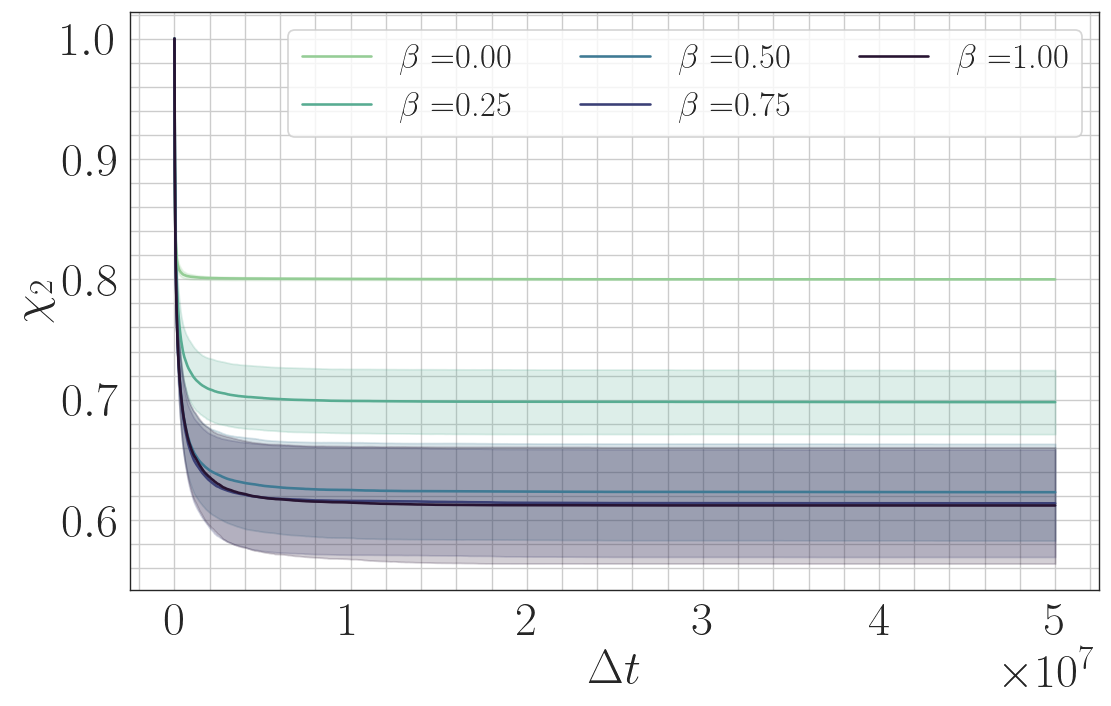

In [21]:
fig, ax = plt.subplots()
labels  = [rf"$\beta=${beta:.02f}" for beta in betas]
cmap    = cubehelix_palette(n_colors=6, start=.5, rot=-.75, light=.85, dark=.1, hue=1, gamma=.95)


# chi2
for kk, traj in enumerate(chi2_trajs):
    mean, std = np.mean(traj, axis=0), np.std(traj, axis=0)
    lb  = np.quantile(traj, q=0.1, axis=0)
    med = np.median(traj, axis=0)
    ub  = np.quantile(traj, q=0.9, axis=0)
    ax.plot(dts, mean, color=cmap[kk+1], label=labels[kk])
    ax.fill_between(dts, mean-std, mean+std, color=cmap[kk+1], alpha=0.2)


ax.set_ylabel(rf"$\chi_2$")
ax.set_xlabel(rf"$\Delta t$")
ax.legend(ncol=3)

Text(0.5, 0, '$\\Delta t$')

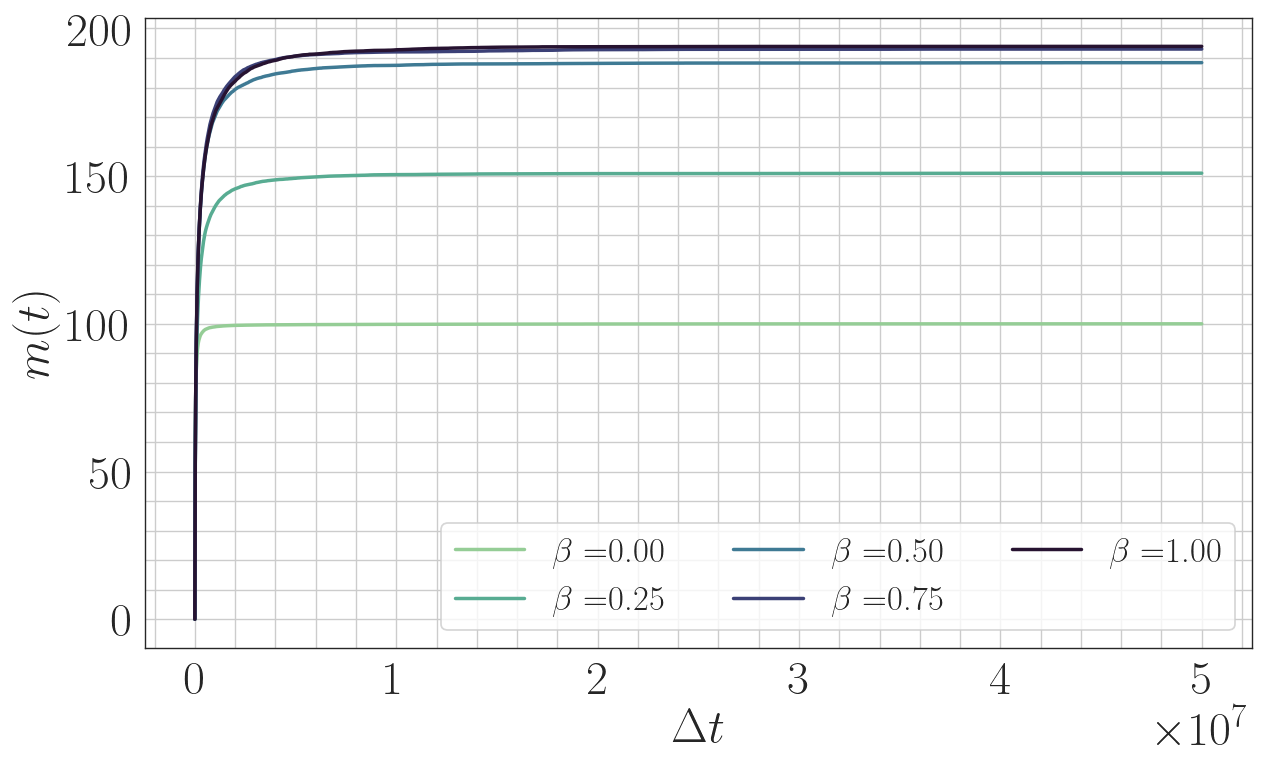

In [15]:
mean_chi2  = np.mean(chi2_trajs, axis=1)
mean_subst = 0.5*(L - L*mean_chi2)


## substitution plot
fig, ax = plt.subplots(constrained_layout=True)
labels = [rf"$\beta=${beta:.02f}" for beta in betas]
cmap = cubehelix_palette(n_colors=6, start=.5, rot=-.75, light=.85, dark=.1, hue=1, gamma=.95)


for kk, subst_traj in enumerate(mean_subst):
    ax.plot(dts, subst_traj, ls='-',  color=cmap[kk+1], lw=2, label=rf"$\beta=${betas[kk]:.02f}")


ax.legend(ncols=3)
ax.set_ylabel(rf"$m(t)$")
ax.set_xlabel(rf"$\Delta t$")

## \chi_4 visualization

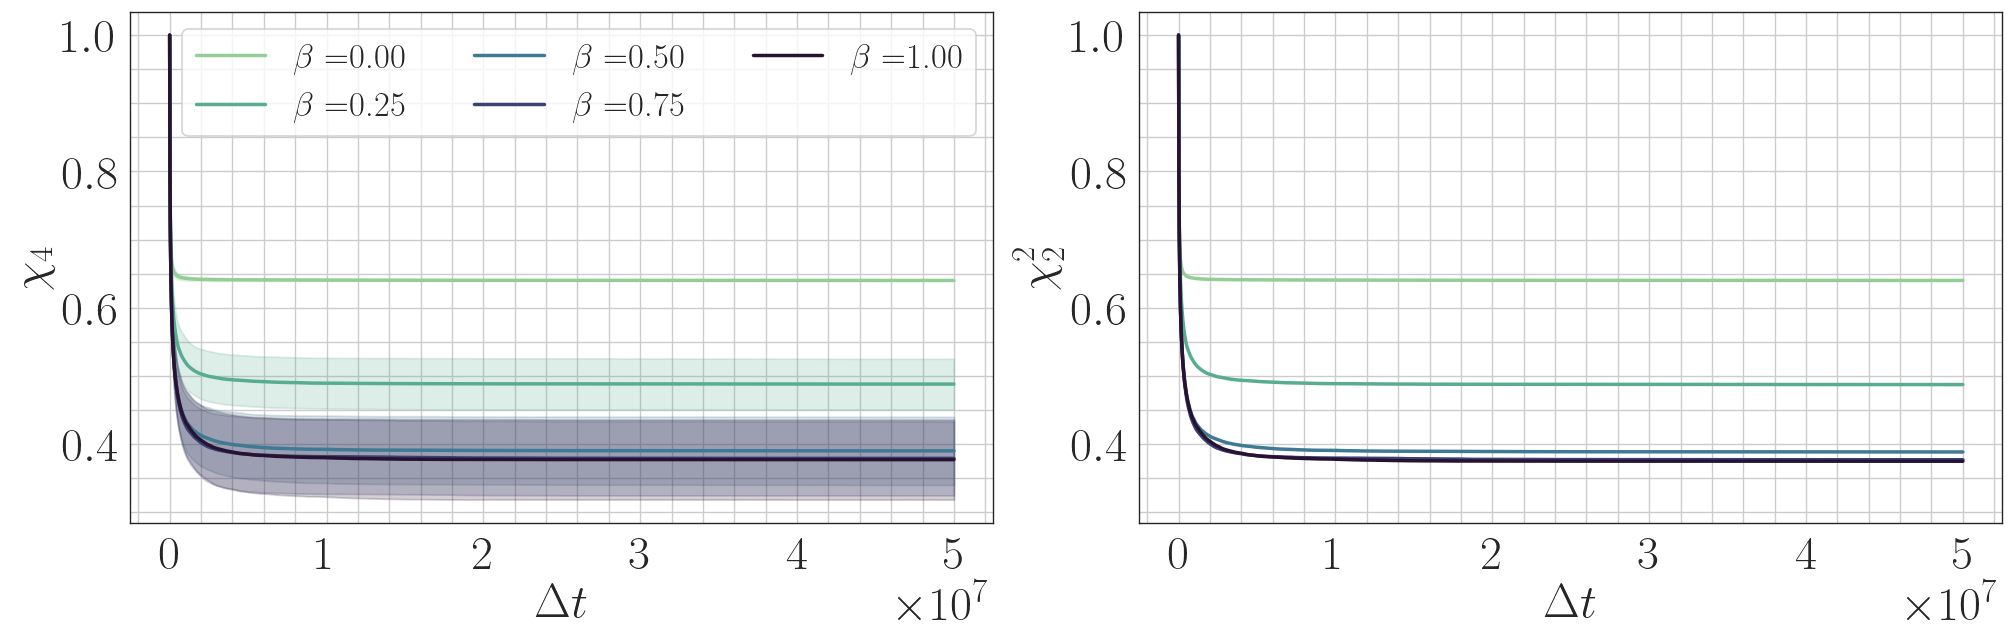

In [46]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 5), constrained_layout=True)
labels  = [rf"$\beta=${beta:.02f}" for beta in betas]
cmap    = cubehelix_palette(n_colors=6, start=.5, rot=-.75, light=.85, dark=.1, hue=1, gamma=.95)


# chi4
for kk, traj in enumerate(four_pt):
    mean, std = np.mean(traj, axis=0), np.std(traj, axis=0)
    axs[0].plot(dts, mean, color=cmap[kk+1], label=rf"$\beta=${betas[kk]:.02f}", lw=2)
    axs[0].fill_between(dts, mean-std, mean+std, color=cmap[kk+1], alpha=0.2)


axs[0].set_ylabel(rf"$\chi_4$")
axs[0].set_xlabel(rf"$\Delta t$")
axs[0].legend(ncol=3)


# chi2^2
for kk, traj in enumerate(chi2_trajs):
    mean = np.mean(traj, axis=0)**2
    axs[1].plot(dts, mean, color=cmap[kk+1], label=labels[kk], lw=2)


axs[1].set_ylim(axs[0].get_ylim())
axs[1].set_ylabel(rf"$\chi_2^2$")
axs[1].set_xlabel(rf"$\Delta t$")
    

plt.savefig(f'/scratch/nb3397/results/lenski/chi2/chi2_chi4_7_18_23.pdf', dpi=300, transparent=True, bbox_inches='tight')

# Exponent Fitting

In [18]:
from scipy.optimize import curve_fit
from scipy.stats import sem

def power_law(dt: float, a: float, gamma: float, C: float):
    return C + (1 - C) / ((1 + a*dt)**gamma)

### Compute bootstrap distribution over parameters

In [24]:
nboots         = 200
chi2_exps      = onp.zeros((nbetas, nboots, 3))
chi2_stretched = onp.zeros((nbetas, nboots, 3))

for ii, beta_traj in enumerate(chi2_trajs):
    for exps, func_form in zip([chi2_exps, chi2_stretched], [power_law, stretched_exponential]):
        n_successes = 0
        nfails = 0
        while n_successes < nboots:
            try:
                selections = onp.random.randint(nsims, size=nsims)
                mean_traj  = onp.mean(beta_traj[selections], axis=0)
                sem_traj   = sem(beta_traj[selections], axis=0)
                C_estimate = mean_traj[-1]

                inds = sem_traj > 0
                if ii == 0:
                    sem_traj = np.ones_like(mean_traj)
                    dts_est = dts
                else:
                    mean_traj  = mean_traj[inds]
                    sem_traj   = sem_traj[inds]
                    dts_est    = dts[inds]

                #     [tau,    gamma,  C]
                lbs = [0,        0,    0.8*C_estimate]
                ubs = [np.inf, np.inf, 1.2*C_estimate]
                p0  = [1e-5,    0.25,      C_estimate]

                rslts = curve_fit(
                    func_form,
                    dts_est,
                    mean_traj,
                    sigma=sem_traj,
                    bounds=(lbs, ubs),
                    tr_solver='exact',
                    p0=p0,
                    absolute_sigma=True,
                    max_nfev=1e5
                )

                if n_successes % (nboots // 10) == 0:
                    print(f'Finished {n_successes+1}/{nboots} on {ii+1}/{nbetas}.')

                exps[ii, n_successes] = rslts[0]
                n_successes += 1
            except:
                print(f'Failed on {n_successes+1}/{nboots} on {ii+1}/{nbetas}.')
                nfails += 1

                # break out of infinite loop
                if nfails == 100:
                    assert 1 == 0

        print(f'Finished {ii+1}/{nbetas}')

Finished 1/200 on 1/5.
Finished 21/200 on 1/5.
Finished 41/200 on 1/5.
Finished 61/200 on 1/5.
Finished 81/200 on 1/5.
Finished 101/200 on 1/5.
Finished 121/200 on 1/5.
Finished 141/200 on 1/5.
Finished 161/200 on 1/5.
Finished 181/200 on 1/5.
Finished 1/5
Finished 1/200 on 1/5.
Finished 21/200 on 1/5.
Finished 41/200 on 1/5.
Finished 61/200 on 1/5.
Finished 81/200 on 1/5.
Finished 101/200 on 1/5.
Finished 121/200 on 1/5.
Finished 141/200 on 1/5.
Finished 161/200 on 1/5.
Finished 181/200 on 1/5.
Finished 1/5
Finished 1/200 on 2/5.
Finished 21/200 on 2/5.
Finished 41/200 on 2/5.
Finished 61/200 on 2/5.
Finished 81/200 on 2/5.
Finished 101/200 on 2/5.
Finished 121/200 on 2/5.
Finished 141/200 on 2/5.
Finished 161/200 on 2/5.
Finished 181/200 on 2/5.
Finished 2/5
Finished 1/200 on 2/5.
Finished 21/200 on 2/5.
Finished 41/200 on 2/5.
Finished 61/200 on 2/5.
Finished 81/200 on 2/5.
Finished 101/200 on 2/5.
Finished 121/200 on 2/5.
Finished 141/200 on 2/5.
Finished 161/200 on 2/5.
Finished 1

## Exponent and fit plot

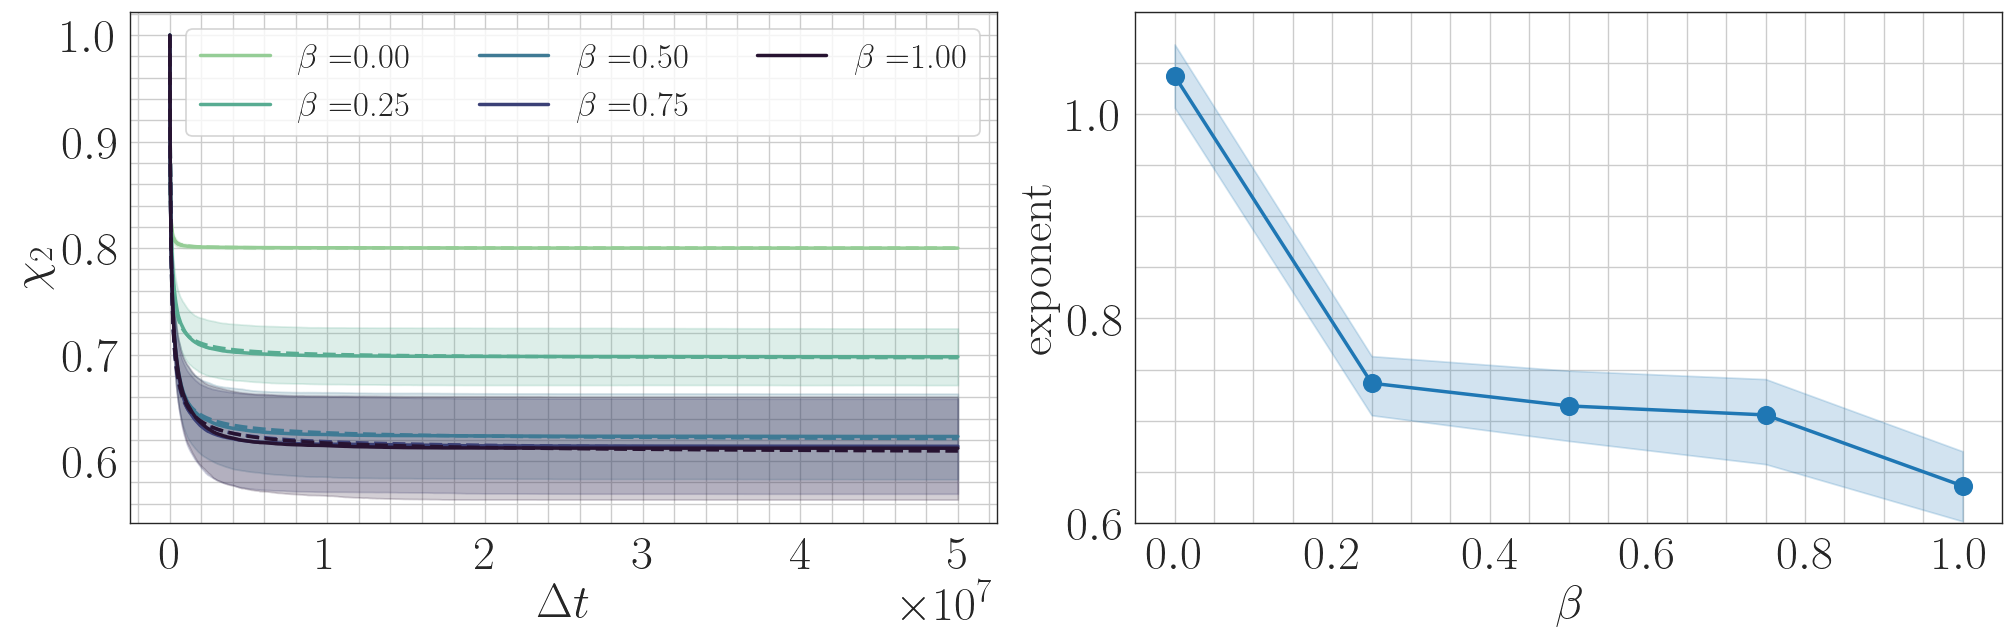

In [41]:
## exponent plot
fig, axs = plt.subplots(figsize=(16, 5), nrows=1, ncols=2, constrained_layout=True)

lb  = np.quantile(chi2_exps[:, :, 1], q=0.025, axis=1)
med = np.median(chi2_exps[:, :, 1], axis=1)
ub  = np.quantile(chi2_exps[:, :, 1], q=0.975, axis=1)

axs[1].plot(betas, med, marker='o', lw=2, ms=10)
axs[1].fill_between(betas, lb, ub, alpha=0.2, color='C0')
axs[1].set_ylim([0.6, 1.1])
axs[1].set_xlabel(r"$\beta$")
axs[1].set_ylabel(r"exponent")


## fit plot
labels = [rf"$\beta=${beta:.02f}" for beta in betas]
cmap = cubehelix_palette(n_colors=6, start=.5, rot=-.75, light=.85, dark=.1, hue=1, gamma=.95)
chi2_est_trajs = jax.vmap(lambda params: power_law(dts, *params))(np.median(chi2_exps, axis=1))

for kk, (traj, est_traj) in enumerate(zip(chi2_trajs, chi2_est_trajs)):
    mean, std = np.mean(traj, axis=0), np.std(traj, axis=0)
    axs[0].fill_between(dts, mean-std, mean+std, color=cmap[kk+1], alpha=0.2)
    axs[0].plot(dts, mean,     ls='-',  color=cmap[kk+1], lw=2, label=rf"$\beta=${betas[kk]:.02f}")
    axs[0].plot(dts, est_traj, ls='--', color=cmap[kk+1], lw=2)
    
axs[0].legend(ncols=3)
axs[0].set_ylabel(rf"$\chi_2$")
axs[0].set_xlabel(rf"$\Delta t$")

plt.savefig(f'/scratch/nb3397/results/lenski/chi2/exponents_7_17_23.pdf', dpi=300, transparent=True, bbox_inches='tight')

## Comparison to stretched exponential

In [ ]:
fig, axs = plt.subplots(figsize=(16, 16), nrows=2, ncols=2, constrained_layout=True)
labels   = [rf"$\beta=${beta:.02f}" for beta in betas]
cmap     = cubehelix_palette(n_colors=6, start=.5, rot=-.75, light=.85, dark=.1, hue=1, gamma=.95)

for jj, (exps, func_form) in enumerate(zip([chi2_exps, chi2_stretched], [power_law, stretched_exponential_jax])):
    ## exponent plot
    lb  = np.quantile(exps[:, :, 1], q=0.025, axis=1)
    med = np.median(exps[:, :, 1], axis=1)
    ub  = np.quantile(exps[:, :, 1], q=0.975, axis=1)

    axs[0, jj].plot(betas, med, marker='o', lw=2, ms=5)
    axs[0, jj].fill_between(betas, lb, ub, alpha=0.2, color='C0')
#     axs[0, jj].set_ylim([0.6, 1.1])
    axs[0, jj].set_xlabel(r"$\beta$")
    axs[0, jj].set_ylabel(r"exponent")


    ## fit plot
    chi2_est_trajs = jax.vmap(lambda params: func_form(dts, *params))(np.median(exps, axis=1))

    for kk, (traj, est_traj) in enumerate(zip(chi2_trajs, chi2_est_trajs)):
        mean, std = np.mean(traj, axis=0), np.std(traj, axis=0)
        axs[1, jj].fill_between(dts, mean-std, mean+std, color=cmap[kk+1], alpha=0.2)
        axs[1, jj].plot(dts, mean,     ls='-',  color=cmap[kk+1], lw=2, label=rf"$\beta=${betas[kk]:.02f}")
        axs[1, jj].plot(dts, est_traj, ls='--', color=cmap[kk+1], lw=2)

    axs[1, jj].legend(ncols=3)
    axs[1, jj].set_ylabel(rf"$\chi_2$")
    axs[1, jj].set_xlabel(rf"$\Delta t$")


# Save data

In [70]:
data_dict = {
    'spins': spins,
    'fits': fits,
    'ts': ts,
    'dFs': dFs,
    'betas': betas,
    'chi2_trajs': chi2_trajs,
    'chi2_exps': chi2_exps,
    'dts': dts
}

output_folder = '/scratch/nb3397/results/lenski/chi2'
output_name = None

pickle.dump(data_dict, open(f'{output_folder}/{output_name}', 'wb'))

# Load data

In [6]:
output_folder = '/scratch/nb3397/results/lenski/chi2'
output_name = '7_11_23.npy'
data_dict = pickle.load(open(f'{output_folder}/{output_name}', 'rb'))

L          = 1000
dts        = data_dict['dts']
chi2_trajs = data_dict['chi2_trajs']
fits       = data_dict['fits']
dFs        = data_dict['dFs']
ts         = data_dict['ts']
spins      = data_dict['spins']
nbetas, nsims, nfixed_muts, L = dFs.shape
nfixed_muts -= 1
betas      = np.linspace(0, 1.0, nbetas)

# Mean-Field Figures

## Substitution Trajectory: No time

In [66]:
mean_chi2  = np.mean(chi2_trajs, axis=1)
mean_subst = 0.5*(L - L*mean_chi2)
ranks      = np.sum(dFs > 0, axis=-1)
nbetas, nsims, nfixed_muts = fits.shape
nfixed_muts -= 1
betas = np.linspace(0.0, 1.0, nbetas)

mean_beneficial_dFs = onp.zeros((nbetas, nsims, nfixed_muts+1))
for ii in range(nbetas):
    for jj in range(nsims):
        for kk in range(nfixed_muts+1):
            curr_dFs = dFs[ii, jj, kk]
            inds = curr_dFs > 0
            if np.sum(inds) > 0:
                mean_beneficial_dFs[ii, jj, kk] = np.mean(curr_dFs[inds])
            else:
                mean_beneficial_dFs[ii, jj, kk] = 0

Text(0, 0.5, '$\\langle \\dot m \\rangle$')

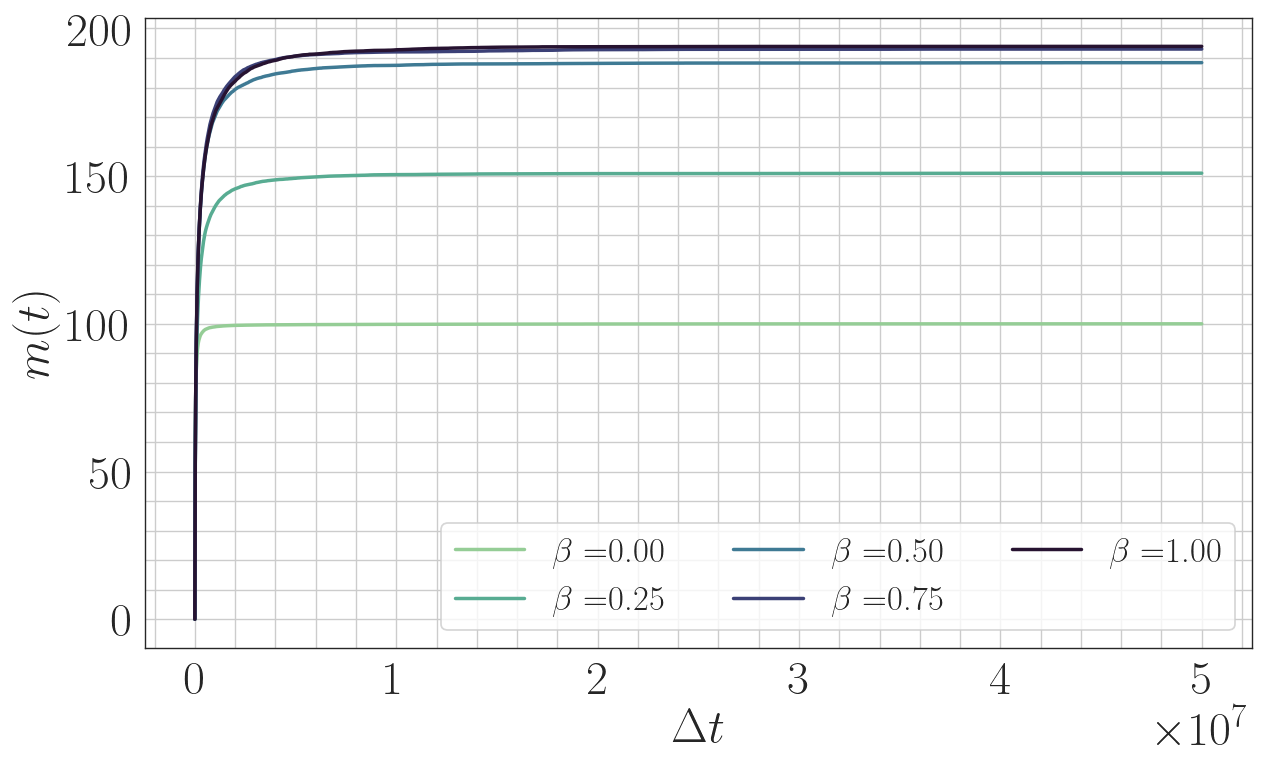

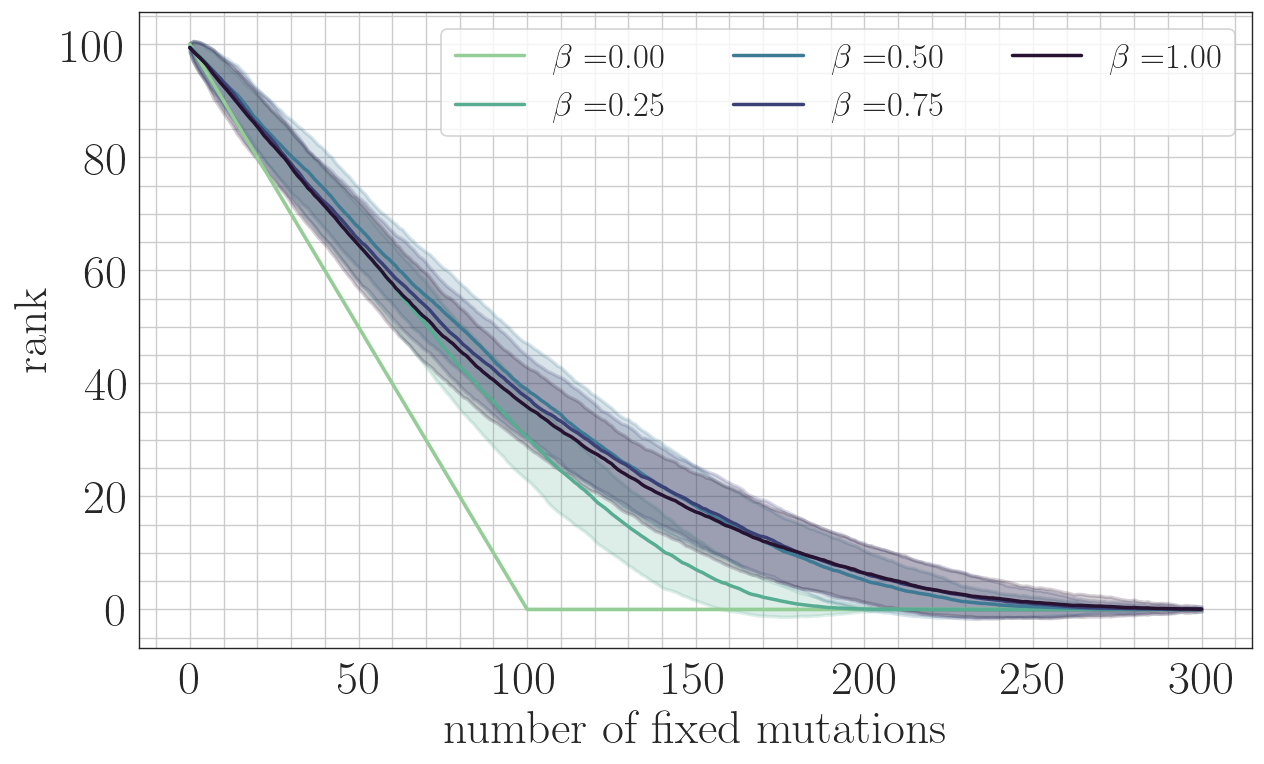

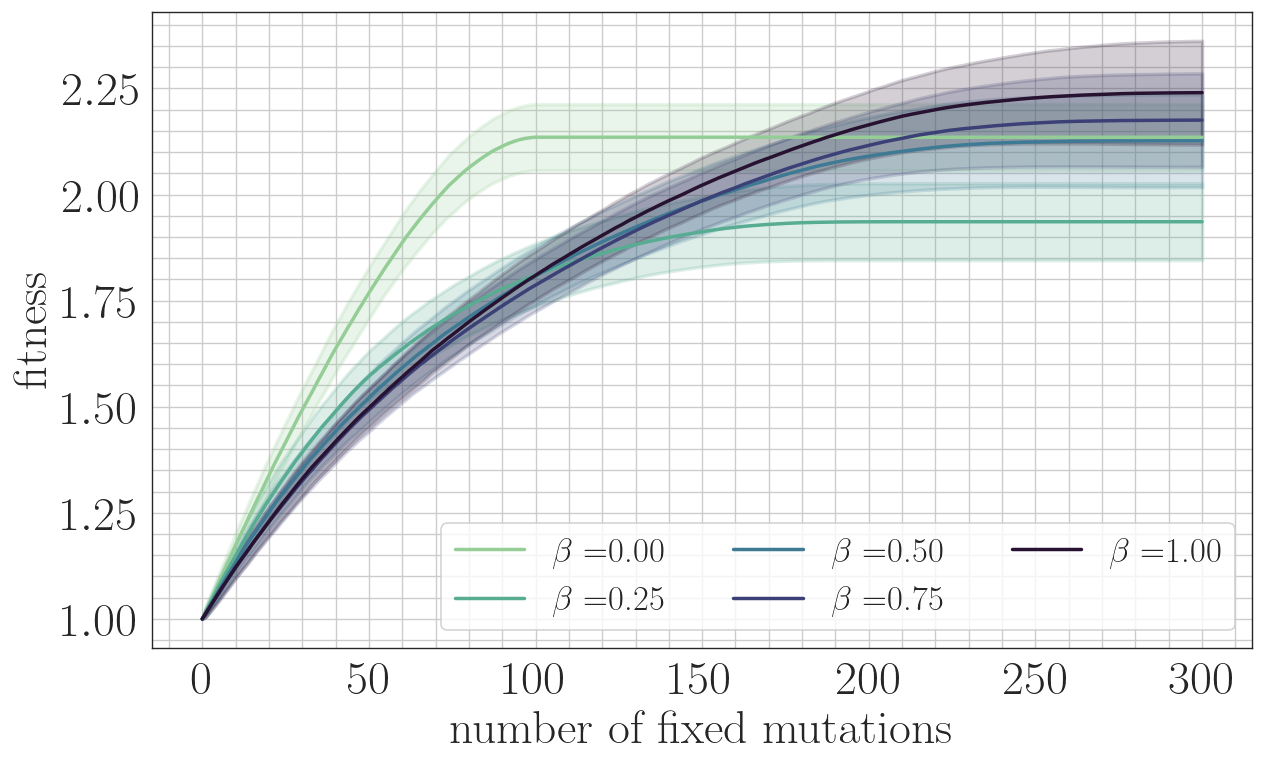

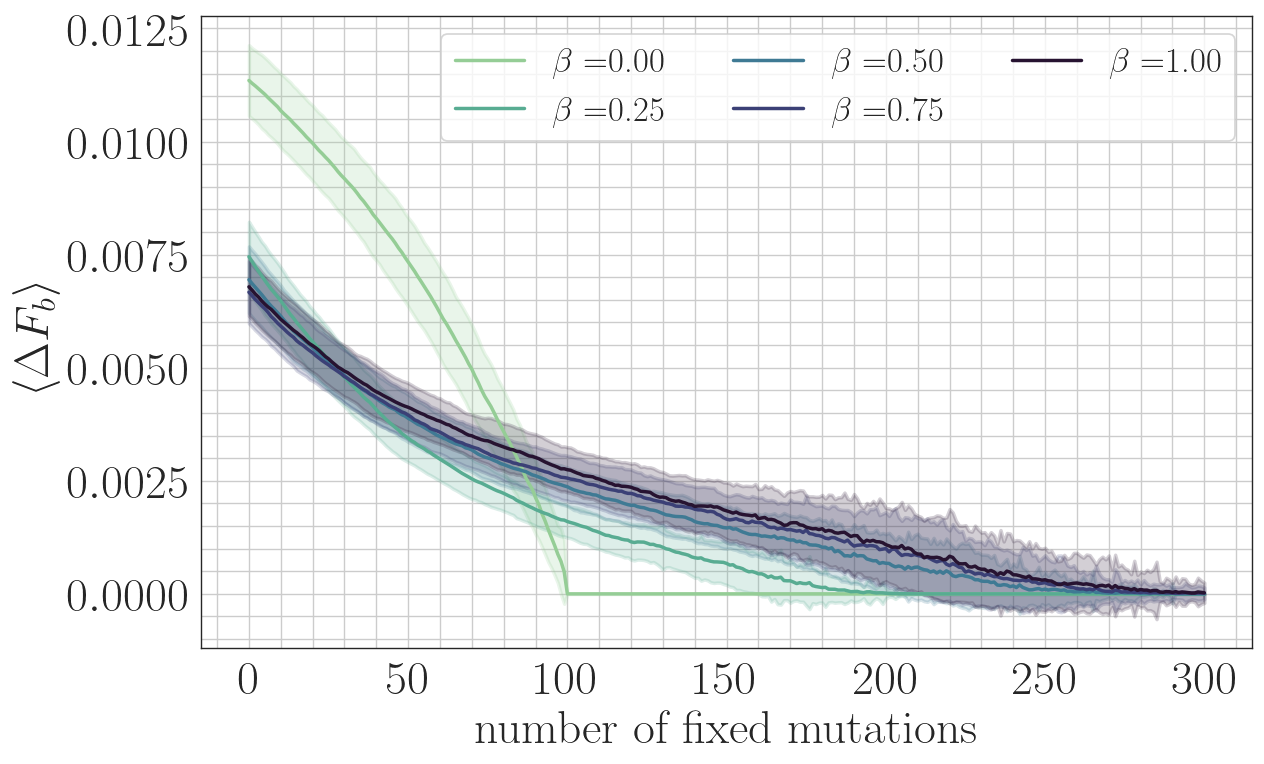

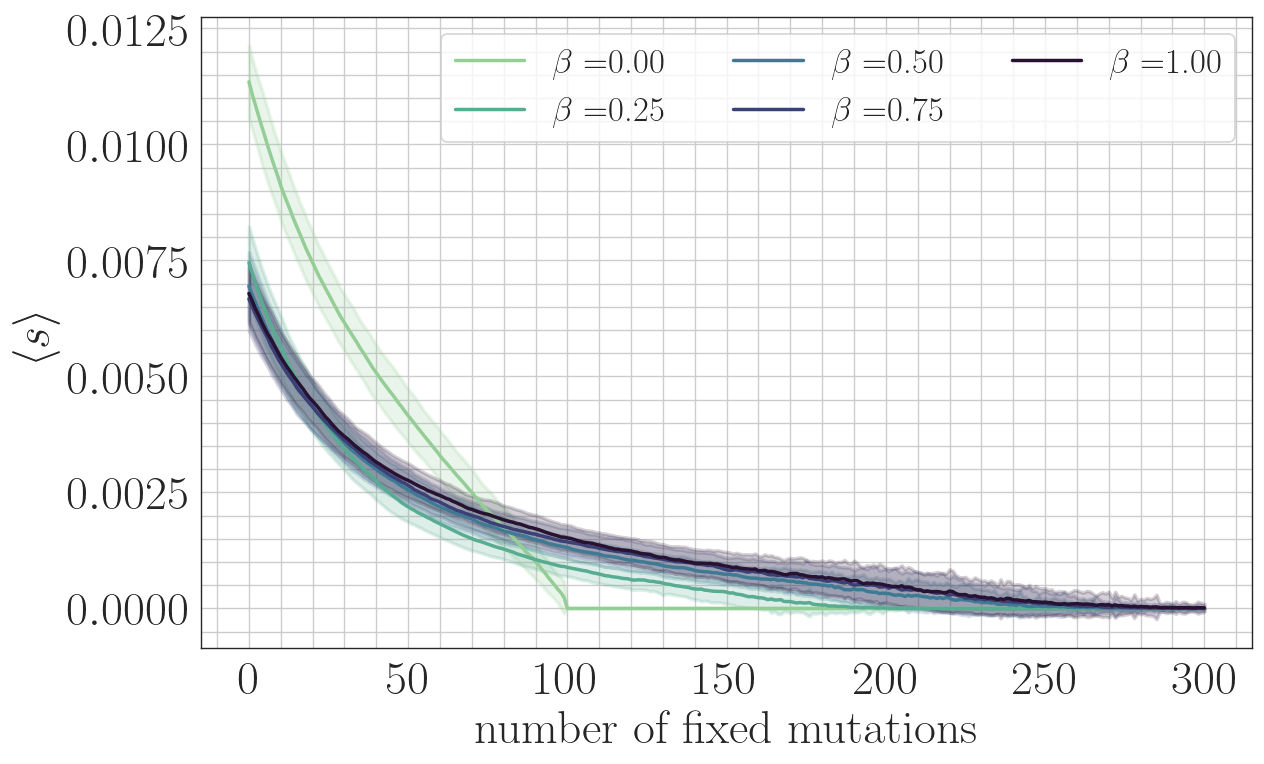

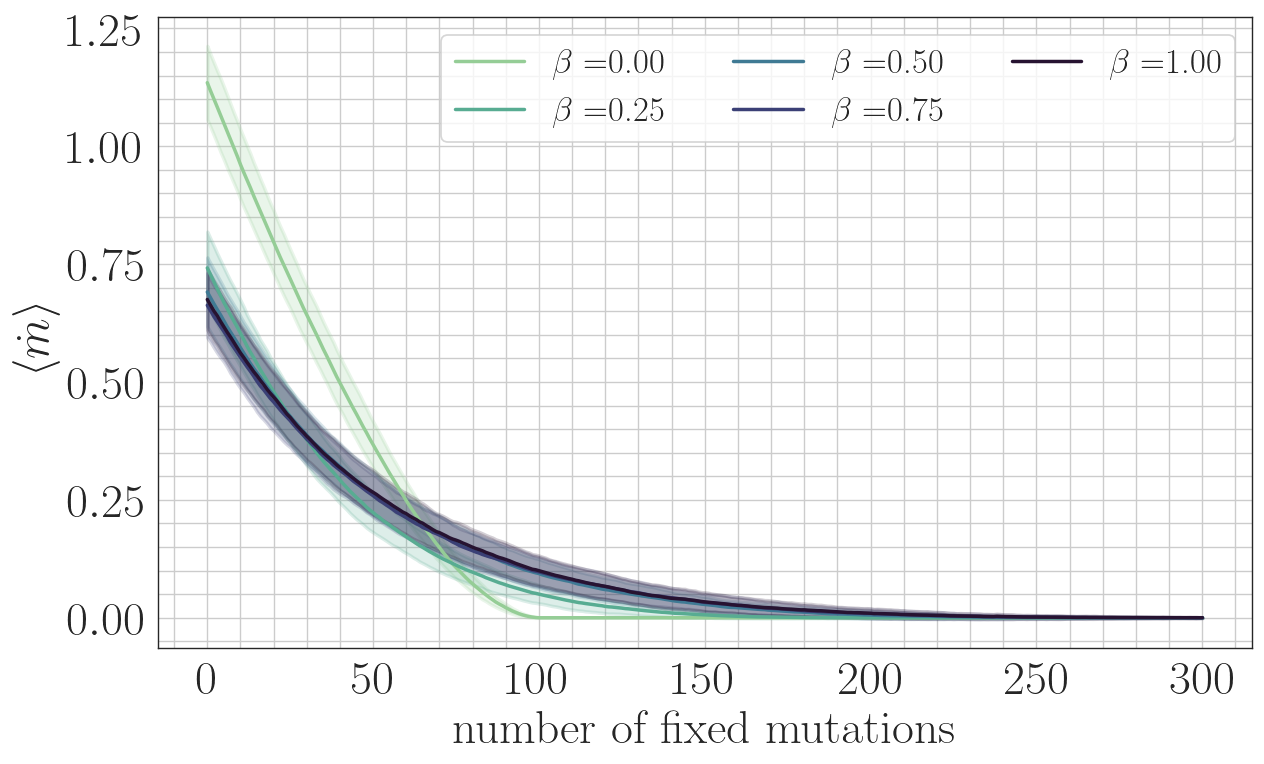

In [67]:
## substitution plot
fig, ax = plt.subplots(constrained_layout=True)
labels = [rf"$\beta=${beta:.02f}" for beta in betas]
cmap = cubehelix_palette(n_colors=6, start=.5, rot=-.75, light=.85, dark=.1, hue=1, gamma=.95)


for kk, subst_traj in enumerate(mean_subst):
    ax.plot(dts, subst_traj, ls='-',  color=cmap[kk+1], lw=2, label=rf"$\beta=${betas[kk]:.02f}")


ax.legend(ncols=3)
ax.set_ylabel(rf"$m(t)$")
ax.set_xlabel(rf"$\Delta t$")


## rank plot
fig, ax = plt.subplots(constrained_layout=True)
labels = [rf"$\beta=${beta:.02f}" for beta in betas]
cmap = cubehelix_palette(n_colors=6, start=.5, rot=-.75, light=.85, dark=.1, hue=1, gamma=.95)


for kk, rank_traj in enumerate(ranks):
    mean_rank = np.mean(rank_traj, axis=0)
    std_rank = np.std(rank_traj, axis=0)
    ax.plot(mean_rank, ls='-',  color=cmap[kk+1], lw=2, label=rf"$\beta=${betas[kk]:.02f}")
    ax.fill_between(np.arange(mean_rank.size), mean_rank-std_rank, mean_rank+std_rank, ls='-',  color=cmap[kk+1], lw=2, alpha=0.2)

    
ax.legend(ncols=3)
ax.set_xlabel(rf"number of fixed mutations")
ax.set_ylabel(rf"rank")


## fitness plot
fig, ax = plt.subplots(constrained_layout=True)
labels = [rf"$\beta=${beta:.02f}" for beta in betas]
cmap = cubehelix_palette(n_colors=6, start=.5, rot=-.75, light=.85, dark=.1, hue=1, gamma=.95)

for kk, traj in enumerate(fits):
    mean = np.mean(traj, axis=0)
    std = np.std(traj, axis=0)
    ax.plot(mean, ls='-',  color=cmap[kk+1], lw=2, label=rf"$\beta=${betas[kk]:.02f}")
    ax.fill_between(np.arange(mean.size), mean-std, mean+std, ls='-',  color=cmap[kk+1], lw=2, alpha=0.2)
    
ax.legend(ncols=3)
ax.set_xlabel(rf"number of fixed mutations")
ax.set_ylabel(rf"fitness")


## dF plot
fig, ax = plt.subplots(constrained_layout=True)
labels = [rf"$\beta=${beta:.02f}" for beta in betas]
cmap = cubehelix_palette(n_colors=6, start=.5, rot=-.75, light=.85, dark=.1, hue=1, gamma=.95)

for kk, traj in enumerate(mean_beneficial_dFs):
    mean = np.mean(traj, axis=0)
    std = np.std(traj, axis=0)
    ax.plot(mean, ls='-',  color=cmap[kk+1], lw=2, label=rf"$\beta=${betas[kk]:.02f}")
    ax.fill_between(np.arange(mean.size), mean-std, mean+std, ls='-',  color=cmap[kk+1], lw=2, alpha=0.2)
    
ax.legend(ncols=3)
ax.set_xlabel(rf"number of fixed mutations")
ax.set_ylabel(rf"$\langle \Delta F_b\rangle$")


## s plot
fig, ax = plt.subplots(constrained_layout=True)
labels = [rf"$\beta=${beta:.02f}" for beta in betas]
cmap = cubehelix_palette(n_colors=6, start=.5, rot=-.75, light=.85, dark=.1, hue=1, gamma=.95)

for kk, (dF_traj, F_traj) in enumerate(zip(mean_beneficial_dFs, fits)):
    traj = dF_traj / F_traj
    mean = np.mean(traj, axis=0)
    std = np.std(traj, axis=0)
    ax.plot(mean, ls='-',  color=cmap[kk+1], lw=2, label=rf"$\beta=${betas[kk]:.02f}")
    ax.fill_between(np.arange(mean.size), mean-std, mean+std, ls='-', color=cmap[kk+1], lw=2, alpha=0.2)
    
ax.legend(ncols=3)
ax.set_xlabel(rf"number of fixed mutations")
ax.set_ylabel(rf"$\langle s\rangle$")


## \dot{m} plot
fig, ax = plt.subplots(constrained_layout=True)
labels = [rf"$\beta=${beta:.02f}" for beta in betas]
cmap = cubehelix_palette(n_colors=6, start=.5, rot=-.75, light=.85, dark=.1, hue=1, gamma=.95)

for kk, (dF_traj, F_traj, rank_traj) in enumerate(zip(mean_beneficial_dFs, fits, ranks)):
    traj = dF_traj * rank_traj
    mean = np.mean(traj, axis=0)
    std = np.std(traj, axis=0)
    ax.plot(mean, ls='-',  color=cmap[kk+1], lw=2, label=rf"$\beta=${betas[kk]:.02f}")
    ax.fill_between(np.arange(mean.size), mean-std, mean+std, ls='-', color=cmap[kk+1], lw=2, alpha=0.2)
    
ax.legend(ncols=3)
ax.set_xlabel(rf"number of fixed mutations")
ax.set_ylabel(rf"$\langle \dot m \rangle$")

## Substitution Trajectory: Snap to time grid

In [68]:
def snap_to_grid(
    t: float,
    ts: np.ndarray,
    quantity: np.ndarray,
) -> float:
    ind = np.argmax(ts > t)-1
    return quantity[ind]


snap_traj_to_grid       = jax.vmap(snap_to_grid,       in_axes=(0,    None, None))
snap_trajs_to_grid      = jax.vmap(snap_traj_to_grid,  in_axes=(None,    0,    0))
snap_beta_trajs_to_grid = jax.vmap(snap_trajs_to_grid, in_axes=(None,    0,    0))

In [82]:
t_grid                    = dts
subst_trajs               = 0.5*L*(1 - chi2_trajs)
rank_trajs                = snap_beta_trajs_to_grid(t_grid, ts, ranks)
fits_trajs                = snap_beta_trajs_to_grid(t_grid, ts, fits)
mean_beneficial_dFs_trajs = snap_beta_trajs_to_grid(t_grid, ts, mean_beneficial_dFs)

Text(0, 0.5, '$\\langle \\dot m \\rangle$')

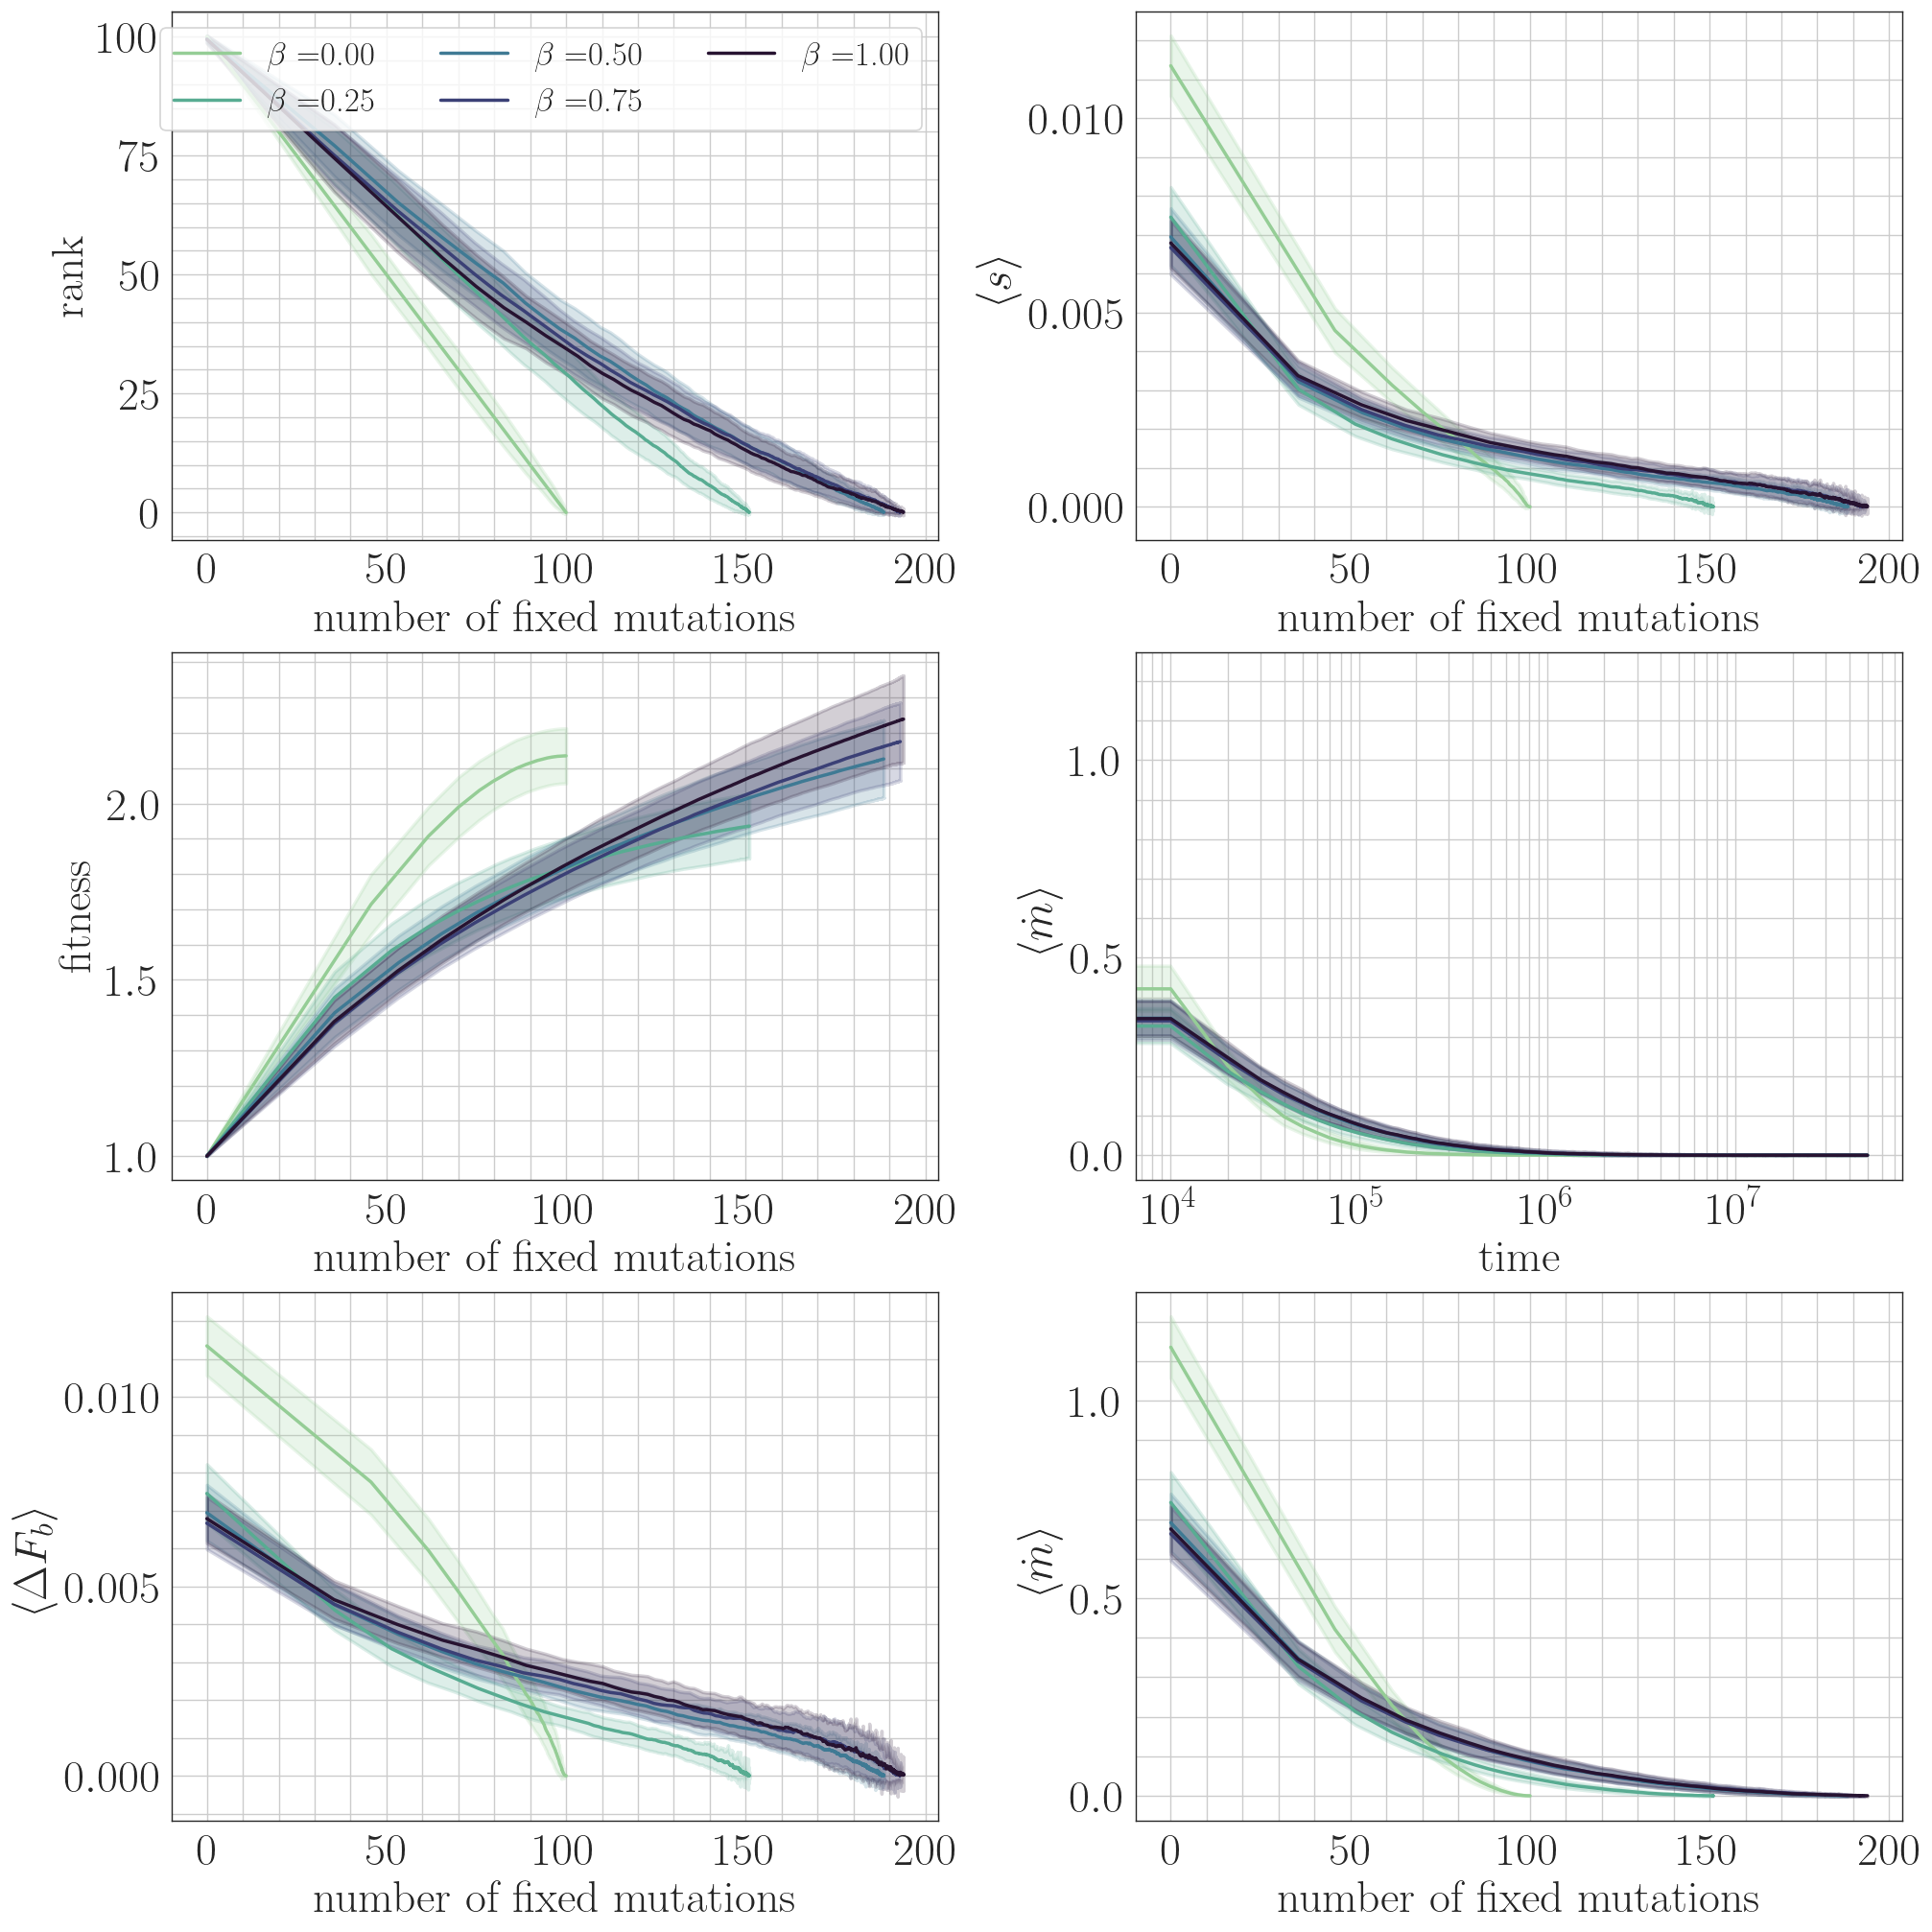

In [83]:
# ## rank plot
fig, axs = plt.subplots(figsize=(16, 16), nrows=3, ncols=2, constrained_layout=True)
labels = [rf"$\beta=${beta:.02f}" for beta in betas]
cmap = cubehelix_palette(n_colors=6, start=.5, rot=-.75, light=.85, dark=.1, hue=1, gamma=.95)


for kk, rank_traj in enumerate(rank_trajs):
    mean_rank = np.mean(rank_traj, axis=0)
    std_rank = np.std(rank_traj, axis=0)
    axs[0, 0].plot(mean_subst[kk], mean_rank, ls='-',  color=cmap[kk+1], lw=2, label=rf"$\beta=${betas[kk]:.02f}")
    axs[0, 0].fill_between(mean_subst[kk], mean_rank-std_rank, mean_rank+std_rank, ls='-',  color=cmap[kk+1], lw=2, alpha=0.2)

    
axs[0, 0].legend(ncols=3)
axs[0, 0].set_xlabel(rf"number of fixed mutations")
axs[0, 0].set_ylabel(rf"rank")


## fitness plot
for kk, traj in enumerate(fits_trajs):
    mean = np.mean(traj, axis=0)
    std = np.std(traj, axis=0)
    axs[1, 0].plot(mean_subst[kk], mean, ls='-',  color=cmap[kk+1], lw=2, label=rf"$\beta=${betas[kk]:.02f}")
    axs[1, 0].fill_between(mean_subst[kk], mean-std, mean+std, ls='-',  color=cmap[kk+1], lw=2, alpha=0.2)
    
# axs[1, 0].legend(ncols=3)
axs[1, 0].set_xlabel(rf"number of fixed mutations")
axs[1, 0].set_ylabel(rf"fitness")


## dF plot
for kk, traj in enumerate(mean_beneficial_dFs_trajs):
    mean = np.mean(traj, axis=0)
    std = np.std(traj, axis=0)
    axs[2, 0].plot(mean_subst[kk], mean, ls='-',  color=cmap[kk+1], lw=2, label=rf"$\beta=${betas[kk]:.02f}")
    axs[2, 0].fill_between(mean_subst[kk], mean-std, mean+std, ls='-',  color=cmap[kk+1], lw=2, alpha=0.2)
    
# axs[2, 0].legend(ncols=3)
axs[2, 0].set_xlabel(rf"number of fixed mutations")
axs[2, 0].set_ylabel(rf"$\langle \Delta F_b\rangle$")


## s plot
for kk, (dF_traj, F_traj) in enumerate(zip(mean_beneficial_dFs_trajs, fits_trajs)):
    traj = dF_traj / F_traj
    mean = np.mean(traj, axis=0)
    std = np.std(traj, axis=0)
    axs[0, 1].plot(mean_subst[kk], mean, ls='-',  color=cmap[kk+1], lw=2, label=rf"$\beta=${betas[kk]:.02f}")
    axs[0, 1].fill_between(mean_subst[kk], mean-std, mean+std, ls='-', color=cmap[kk+1], lw=2, alpha=0.2)
    
# axs[0, 1].legend(ncols=3)
axs[0, 1].set_xlabel(rf"number of fixed mutations")
axs[0, 1].set_ylabel(rf"$\langle s\rangle$")


## \dot{m} plot
for kk, (dF_traj, F_traj, rank_traj) in enumerate(zip(mean_beneficial_dFs_trajs, fits_trajs, rank_trajs)):
    traj = dF_traj * rank_traj
    mean = np.mean(traj, axis=0)
    std = np.std(traj, axis=0)
    axs[1, 1].plot(t_grid, mean, ls='-',  color=cmap[kk+1], lw=2, label=rf"$\beta=${betas[kk]:.02f}")
    axs[1, 1].fill_between(t_grid, mean-std, mean+std, ls='-', color=cmap[kk+1], lw=2, alpha=0.2)

axs[1, 1].set_xscale('log')
# axs[1, 1].legend(ncols=3)
axs[1, 1].set_xlabel(rf"time")
axs[1, 1].set_ylabel(rf"$\langle \dot m \rangle$")


## \dot{m} plot 2
for kk, (dF_traj, F_traj, rank_traj) in enumerate(zip(mean_beneficial_dFs_trajs, fits_trajs, rank_trajs)):
    traj = dF_traj * rank_traj
    mean = np.mean(traj, axis=0)
    std = np.std(traj, axis=0)
    axs[2, 1].plot(mean_subst[kk], mean, ls='-',  color=cmap[kk+1], lw=2, label=rf"$\beta=${betas[kk]:.02f}")
    axs[2, 1].fill_between(mean_subst[kk], mean-std, mean+std, ls='-', color=cmap[kk+1], lw=2, alpha=0.2)

s
# axs[2, 1].legend(ncols=3)
axs[2, 1].set_xlabel(rf"number of fixed mutations")
axs[2, 1].set_ylabel(rf"$\langle \dot m \rangle$")

# plt.savefig(f'/scratch/nb3397/results/lenski/chi2/mean_field_7_11_23.pdf', dpi=300, transparent=True, bbox_inches='tight')

In [130]:
from scipy.signal import savgol_filter

In [132]:
savgol_filter(mean_mean_beneficial_dFs_trajs[4], window_length=25, polyorder=3)

(5000,)

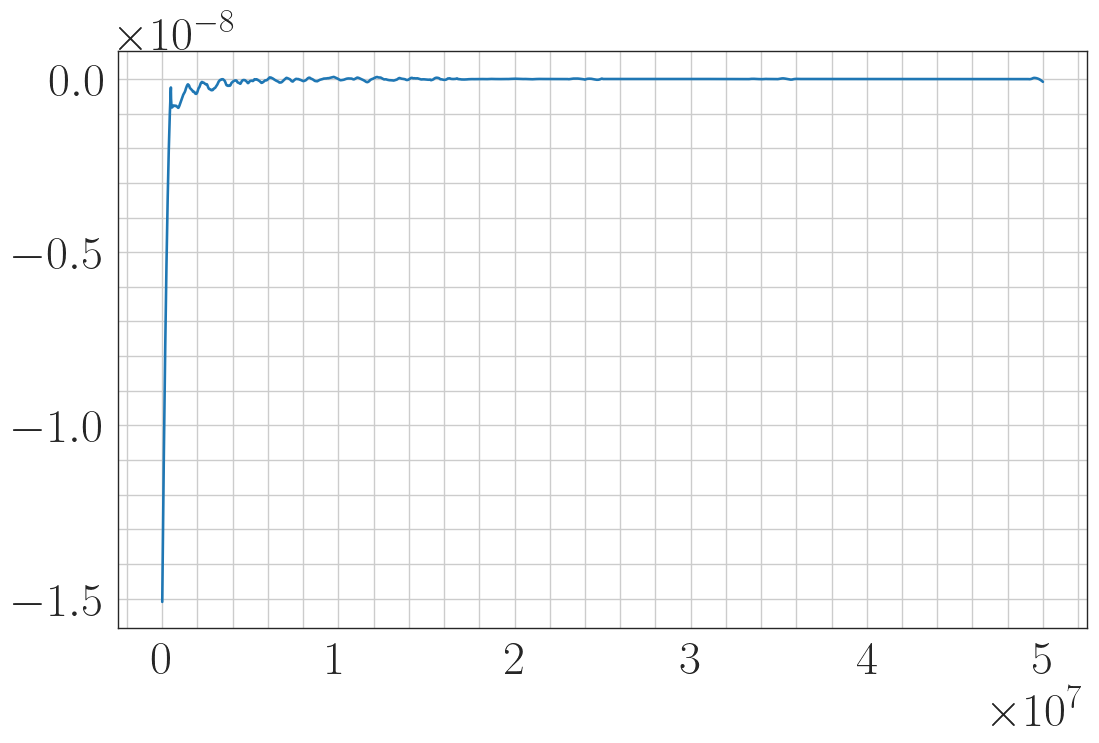

In [162]:
fig, ax = plt.subplots()
# ax.plot(t_grid, mean_mean_beneficial_dFs_trajs[4])
ax.plot(
    t_grid, 
    savgol_filter(mean_mean_beneficial_dFs_trajs[4], window_length=100, polyorder=3, deriv=1, delta=np.diff(t_grid)[0])
)

In [178]:
mean_fit_trajs                 = np.mean(fits_trajs, axis=1)
mean_subst_trajs               = np.mean(subst_trajs, axis=1)
mean_mean_beneficial_dFs_trajs = np.mean(mean_beneficial_dFs_trajs, axis=1)
F_dots                         = np.diff(mean_fit_trajs, axis=1) / np.diff(t_grid)[None, :]
m_dots                         = np.diff(mean_fit_trajs, axis=1) / np.diff(t_grid)[None, :]

In [182]:
mean_mean_beneficial_dFs_trajs.shape

(5, 5000)

In [183]:
F_dots.shape

(5, 4999)

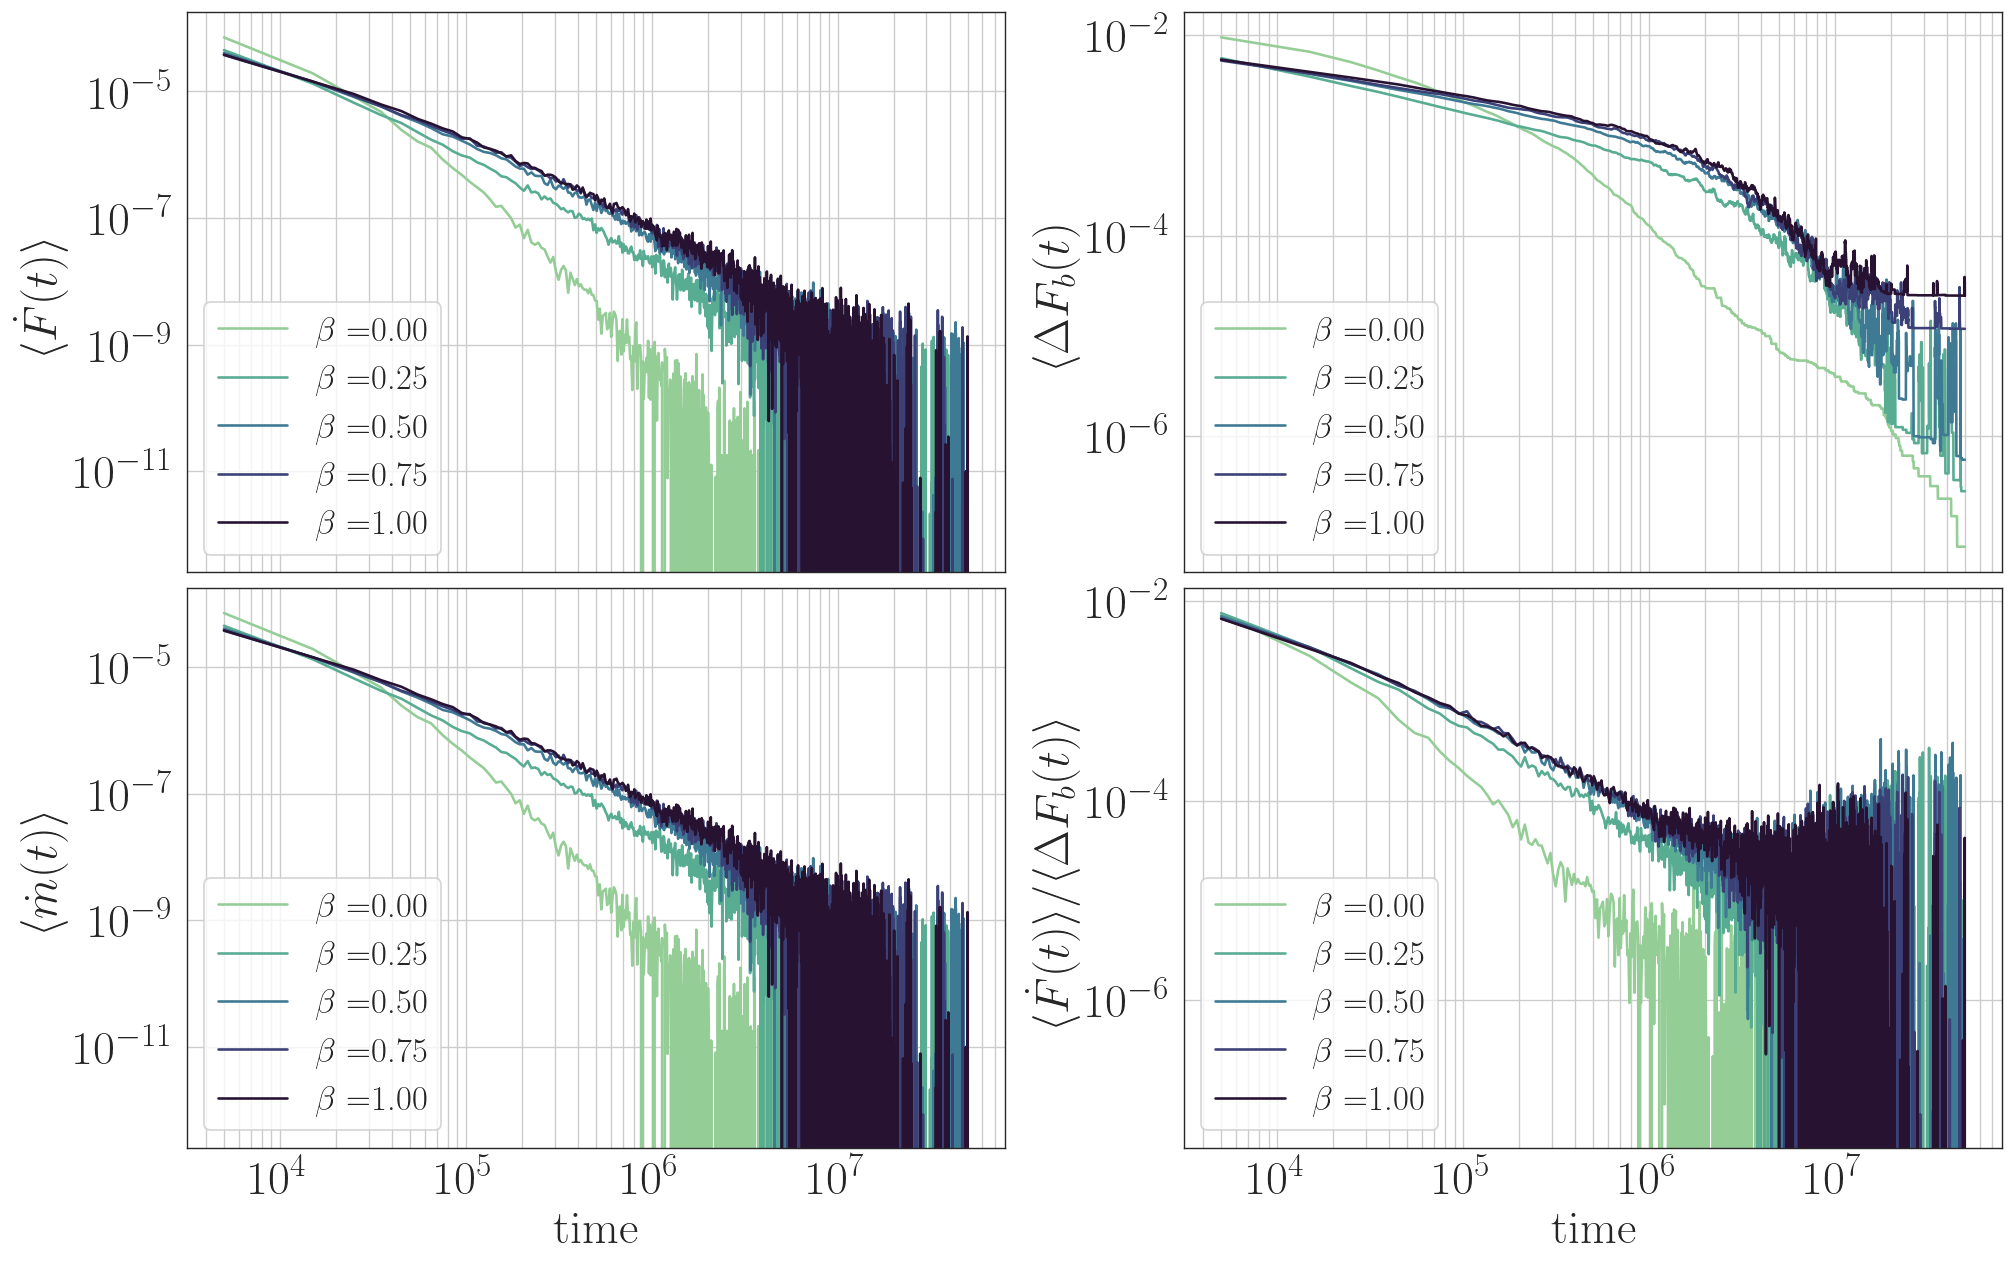

In [192]:
centered_t_grid = t_grid[:-1] + 0.5*np.diff(t_grid)
centered_dFs    = mean_mean_beneficial_dFs_trajs[:, :-1] + 0.5*np.diff(mean_mean_beneficial_dFs_trajs, axis=1)

vals     = [[F_dots, centered_dFs],
            [m_dots, F_dots / centered_dFs]]

ylabels  = [[r"$\langle \dot F(t)\rangle$", r"$\langle \Delta F_b(t)$"],
            [r"$\langle \dot m(t)\rangle$", r"$\langle \dot F(t)\rangle / \langle \Delta F_b(t)\rangle$"]]

nrows    = len(vals)
ncols    = len(vals[0])
fw       = 8
fh       = 5
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(fw*2, fh*2), constrained_layout=True, sharex=True)
labels   = [rf"$\beta=${beta:.02f}" for beta in betas]
cmap     = cubehelix_palette(n_colors=6, start=.5, rot=-.75, light=.85, dark=.1, hue=1, gamma=.95)


for ii in range(nrows):
    for jj in range(ncols):
        curr_vals = vals[ii][jj]
        for kk, curr_val in enumerate(curr_vals):
            axs[ii, jj].plot(centered_t_grid, curr_val, label=labels[kk], color=cmap[kk+1])


        axs[ii, jj].set_xscale('log')
        axs[ii, jj].set_yscale('log')
        axs[ii, jj].legend()
        axs[ii, jj].set_ylabel(ylabels[ii][jj])
        
        if ii == 1:
            axs[ii, jj].set_xlabel('time')
        
plt.savefig(f'/scratch/nb3397/results/lenski/chi2/mean_field_comparison_7_14_23.pdf', dpi=300, transparent=True, bbox_inches='tight')